In [1]:
!pip install pandas==1.5.3

import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

print(pd.__version__)

1.5.3


In [2]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 126D-D836

 Directory of C:\Users\smufl\Downloads\Day2\NVDI_SVM

27/04/2024  19:13    <DIR>          .
27/04/2024  19:30    <DIR>          ..
27/04/2024  16:58    <DIR>          .ipynb_checkpoints
27/04/2024  13:58             9,654 modis_ndvi_series.csv
27/04/2024  19:13           214,699 NDVI_forecasting.ipynb
               2 File(s)        224,353 bytes
               3 Dir(s)  813,581,365,248 bytes free


In [3]:
data = pd.read_csv('modis_ndvi_series.csv')
data = data.filter(regex=r'loc|20')
data.head()

,2002_01_01,2002_01_17,2002_02_02,2002_02_18,2002_03_06,2002_03_22,2002_04_07,2002_04_23,2002_05_09,2002_05_25,...,2021_08_13,2021_08_29,2021_09_14,2021_09_30,2021_10_16,2021_11_01,2021_11_17,2021_12_03,2021_12_19,loc
0,0.14,0.15,0.15,0.16,0.16,0.16,0.16,0.15,0.14,0.13,...,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.14,0.14,L1
1,0.14,0.15,0.15,0.16,0.16,0.16,0.16,0.15,0.14,0.13,...,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.14,0.14,L2


# Computing annual means to remove seasonality.


In [4]:
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt=melt[(melt['NDVI']>0)]   # remove negative values

# get locations

melt['location'] = melt['loc'].str.extract('(\d+)', expand=False).astype(int)
melt['year'] = melt['day'].str.extract('(\d+)', expand=False).astype(int)
melt = melt.sort_values(['location', 'year'])
print(melt)

# Computing annual means 

# Assuming 'data' is your DataFrame containing NDVI data

# Melt the DataFrame to long format
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt = melt[(melt['NDVI'] > 0)]  # Remove negative values

# Extract year from the 'day' column
melt['year'] = melt['day'].str.extract('(\d+)', expand=False).astype(int)

# Ensure 'year' column contains only numeric values
melt = melt.dropna(subset=['year'])  # Drop rows with missing year values

# Computing annual means
year_mean = melt.groupby(['year', 'loc']).mean().reset_index()
print(year_mean)


    loc         day  NDVI  location  year
0    L1  2002_01_01  0.14         1  2002
2    L1  2002_01_17  0.15         1  2002
4    L1  2002_02_02  0.15         1  2002
6    L1  2002_02_18  0.16         1  2002
8    L1  2002_03_06  0.16         1  2002
..   ..         ...   ...       ...   ...
911  L2  2021_10_16  0.13         2  2021
913  L2  2021_11_01  0.13         2  2021
915  L2  2021_11_17  0.13         2  2021
917  L2  2021_12_03  0.14         2  2021
919  L2  2021_12_19  0.14         2  2021

[920 rows x 5 columns]
    year loc      NDVI
0   2002  L1  0.135652
1   2002  L2  0.135652
2   2003  L1  0.137391
3   2003  L2  0.137391
4   2004  L1  0.149130
5   2004  L2  0.149130
6   2005  L1  0.133043
7   2005  L2  0.133043
8   2006  L1  0.139565
9   2006  L2  0.139565
10  2007  L1  0.136522
11  2007  L2  0.136522
12  2008  L1  0.123478
13  2008  L2  0.123478
14  2009  L1  0.127391
15  2009  L2  0.127391
16  2010  L1  0.134348
17  2010  L2  0.134348
18  2011  L1  0.129565
19  2011  L2

C:\Users\smufl\AppData\Local\Temp\ipykernel_20344\2189113368.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mean = melt.groupby(['year', 'loc']).mean().reset_index()


# Split dataset

In [5]:
year_mean.index

RangeIndex(start=0, stop=40, step=1)

In [6]:
split_point = 28
melt_train = year_mean[year_mean.index < split_point].copy()
melt_valid = year_mean[year_mean.index >= split_point].copy()

In [7]:
melt_train

,year,loc,NDVI
0,2002,L1,0.135652
1,2002,L2,0.135652
2,2003,L1,0.137391
3,2003,L2,0.137391
4,2004,L1,0.149130
5,2004,L2,0.149130
6,2005,L1,0.133043
7,2005,L2,0.133043
8,2006,L1,0.139565
9,2006,L2,0.139565


In [8]:
melt_valid

,year,loc,NDVI
28,2016,L1,0.150870
29,2016,L2,0.150870
30,2017,L1,0.134783
31,2017,L2,0.134783
32,2018,L1,0.148261
33,2018,L2,0.148261
34,2019,L1,0.200870
35,2019,L2,0.200870
36,2020,L1,0.171739
37,2020,L2,0.171739


# Creating Features and Targets

In [9]:
melt_train['lead1'] = melt_train.groupby("loc")['NDVI'].shift(-1)
melt_train['lead2'] = melt_train.groupby("loc")['NDVI'].shift(-2)
melt_train['lead3'] = melt_train.groupby("loc")['NDVI'].shift(-3)
melt_train['lead4'] = melt_train.groupby("loc")['NDVI'].shift(-4)
melt_train['lead5'] = melt_train.groupby("loc")['NDVI'].shift(-5)

melt_train['lag1'] = melt_train.groupby("loc")['NDVI'].shift(1)
melt_train['lag2'] = melt_train.groupby("loc")['NDVI'].shift(2)
melt_train['lag3'] = melt_train.groupby("loc")['NDVI'].shift(3)

melt_train["diff_1"] = melt_train.groupby("loc")['NDVI'].diff(1)

melt_train

,year,loc,NDVI,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
0,2002,L1,0.135652,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
1,2002,L2,0.135652,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
2,2003,L1,0.137391,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
3,2003,L2,0.137391,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
4,2004,L1,0.149130,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
5,2004,L2,0.149130,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
6,2005,L1,0.133043,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
7,2005,L2,0.133043,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
8,2006,L1,0.139565,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522
9,2006,L2,0.139565,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522


In [10]:
melt_valid['lead1'] = melt_valid.groupby("loc")['NDVI'].shift(-1)
melt_valid['lead2'] = melt_valid.groupby("loc")['NDVI'].shift(-2)
melt_valid['lead3'] = melt_valid.groupby("loc")['NDVI'].shift(-3)
melt_valid['lead4'] = melt_valid.groupby("loc")['NDVI'].shift(-4)
melt_valid['lead5'] = melt_valid.groupby("loc")['NDVI'].shift(-5)

melt_valid['lag1'] = melt_valid.groupby("loc")['NDVI'].shift(1)
melt_valid['lag2'] = melt_valid.groupby("loc")['NDVI'].shift(2)
melt_valid['lag3'] = melt_valid.groupby("loc")['NDVI'].shift(3)

melt_valid["diff_1"] = melt_valid.groupby("loc")['NDVI'].diff(1)

melt_valid

,year,loc,NDVI,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
28,2016,L1,0.150870,0.134783,0.148261,0.200870,0.171739,0.15,NaN,NaN,NaN,NaN
29,2016,L2,0.150870,0.134783,0.148261,0.200870,0.171739,0.15,NaN,NaN,NaN,NaN
30,2017,L1,0.134783,0.148261,0.200870,0.171739,0.150000,NaN,0.150870,NaN,NaN,-0.016087
31,2017,L2,0.134783,0.148261,0.200870,0.171739,0.150000,NaN,0.150870,NaN,NaN,-0.016087
32,2018,L1,0.148261,0.200870,0.171739,0.150000,NaN,NaN,0.134783,0.150870,NaN,0.013478
33,2018,L2,0.148261,0.200870,0.171739,0.150000,NaN,NaN,0.134783,0.150870,NaN,0.013478
34,2019,L1,0.200870,0.171739,0.150000,NaN,NaN,NaN,0.148261,0.134783,0.150870,0.052609
35,2019,L2,0.200870,0.171739,0.150000,NaN,NaN,NaN,0.148261,0.134783,0.150870,0.052609
36,2020,L1,0.171739,0.150000,NaN,NaN,NaN,NaN,0.200870,0.148261,0.134783,-0.029130
37,2020,L2,0.171739,0.150000,NaN,NaN,NaN,NaN,0.200870,0.148261,0.134783,-0.029130


In [11]:
# drop rows without target values

melt_train = melt_train.dropna(subset=['lead1','lead2','lead3','lead4','lead5'])
melt_train


,year,loc,NDVI,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
0,2002,L1,0.135652,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
1,2002,L2,0.135652,0.137391,0.149130,0.133043,0.139565,0.136522,NaN,NaN,NaN,NaN
2,2003,L1,0.137391,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
3,2003,L2,0.137391,0.149130,0.133043,0.139565,0.136522,0.123478,0.135652,NaN,NaN,0.001739
4,2004,L1,0.149130,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
5,2004,L2,0.149130,0.133043,0.139565,0.136522,0.123478,0.127391,0.137391,0.135652,NaN,0.011739
6,2005,L1,0.133043,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
7,2005,L2,0.133043,0.139565,0.136522,0.123478,0.127391,0.134348,0.149130,0.137391,0.135652,-0.016087
8,2006,L1,0.139565,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522
9,2006,L2,0.139565,0.136522,0.123478,0.127391,0.134348,0.129565,0.133043,0.149130,0.137391,0.006522


# Train the model

In [12]:
features = ['NDVI', 'lag1', 'lag2', 'lag3','diff_1']

In [46]:
import time
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor

start_time = time.time()
imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])

ytr = melt_train[['lead1', 'lead2', 'lead3', 'lead4', 'lead5']]

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

multi_svr = MultiOutputRegressor(svr, n_jobs=6)

multi_svr.fit(Xtr, ytr)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time for model training: {execution_time:.2f} seconds")

Execution time for model training: 1.82 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.datasets import make_regression

def measure_svm_runtime(num_samples, num_features, max_samples, step=100):
    sample_sizes = np.arange(1, max_samples, step)
    runtimes = []

    for n in sample_sizes:
        # Generate a random multi-output regression dataset with n samples and a fixed number of features
        X, y = make_regression(n_samples=n, n_features=num_features, n_informative=5, n_targets=5, noise=0.1, random_state=42)
        y = y.reshape(n, -1)  # Reshape y to a 2D array

        imputer = SimpleImputer()
        X = imputer.fit_transform(X)

        svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
        multi_svr = MultiOutputRegressor(svr, n_jobs=6)

        print(n)
        start_time = time.time()
        multi_svr.fit(X, y)  # Train the model
        end_time = time.time()

        runtime = end_time - start_time
        runtimes.append(runtime)

    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, runtimes, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Samples (n)')
    plt.ylabel('Training Time (seconds)')
    plt.title('SVM Training Time vs. Number of Samples')
    plt.grid(True)

    # Calculate the time taken for plotting the graph
    start_plot_time = time.time()
    plt.show()
    end_plot_time = time.time()
    plot_time = end_plot_time - start_plot_time

    total_time = sum(runtimes) + plot_time
    print(f"Total time for model training and plotting: {total_time:.2f} seconds")

measure_svm_runtime(num_samples=10000, num_features=5, max_samples=10000)

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901


# Predicting NDVI  

In [27]:
Xval = imputer.transform(melt_valid[features])
preds = multi_svr.predict(Xval)
preds

array([[0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391]])

In [29]:
preds1 = np.array(preds)
preds1

array([[0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391],
       [0.13630435, 0.13630435, 0.13565217, 0.14217391, 0.14217391]])

In [30]:
preds.shape

(12, 5)

In [31]:
L1_2022_2026=preds[10]
L2_2022_2026=preds[11]

In [32]:
year_arr=np.arange(2022,2027).reshape(-1,1)
L1_arr=L1_2022_2026.reshape(-1,1)
L1_arr_new=np.concatenate((year_arr, L1_arr),axis=1)
df = pd.DataFrame(L1_arr_new, columns = ['year','NDVI'])
df.loc[:,'year']=df.loc[:,'year'].astype(int)
L1_NDVI=year_mean.loc[year_mean['loc'] == 'L1']
# L1_NDVI.loc[:,'year']=L1_NDVI.loc[:,'year'].astype(int)
L1_NDVI=pd.concat([L1_NDVI, df], ignore_index=True)
L1_NDVI

C:\Users\smufl\AppData\Local\Temp\ipykernel_20344\1238754978.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'year']=df.loc[:,'year'].astype(int)


,year,loc,NDVI
0,2002,L1,0.135652
1,2003,L1,0.137391
2,2004,L1,0.149130
3,2005,L1,0.133043
4,2006,L1,0.139565
5,2007,L1,0.136522
6,2008,L1,0.123478
7,2009,L1,0.127391
8,2010,L1,0.134348
9,2011,L1,0.129565


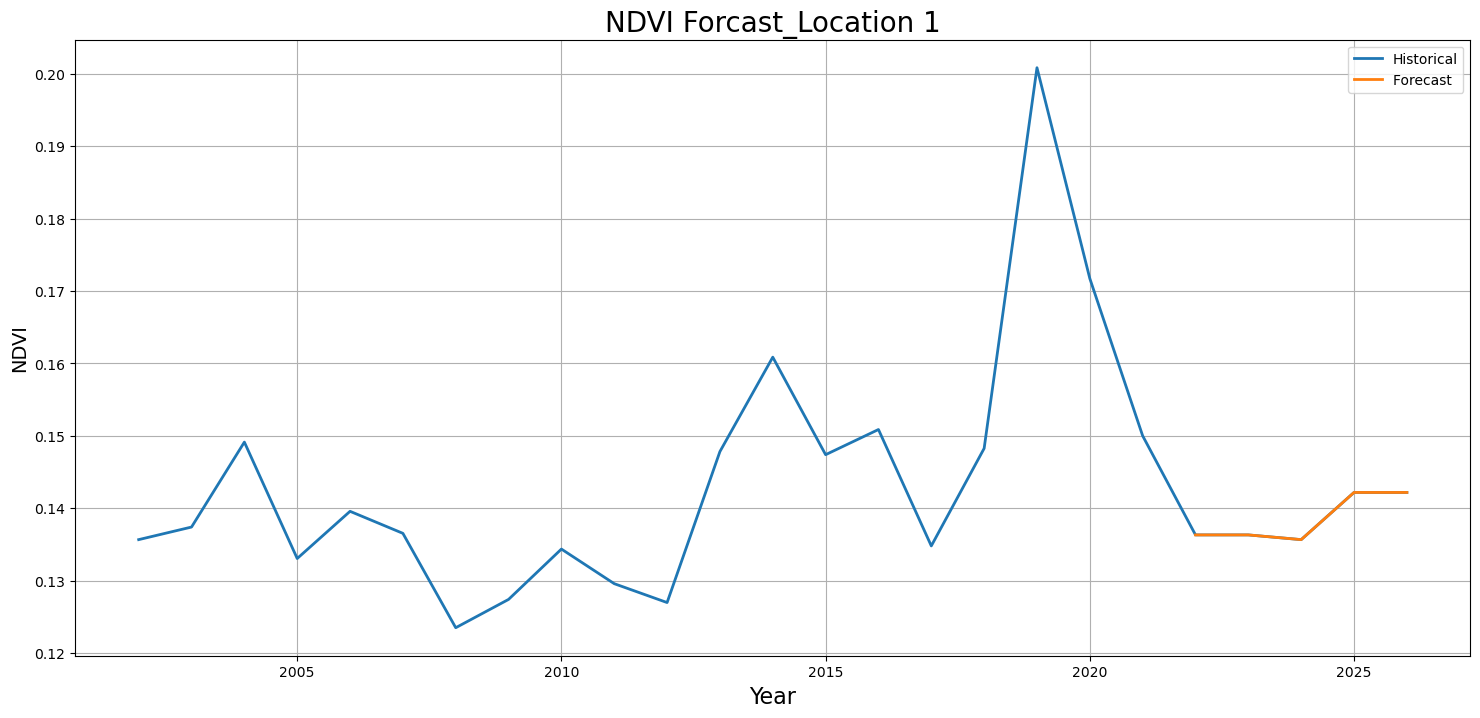

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L1_NDVI['year'], L1_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df['year'], df['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 1",fontsize=20)
ax.grid()
ax.legend();

In [34]:
L2_arr=L2_2022_2026.reshape(-1,1)
L2_arr_new=np.concatenate((year_arr, L2_arr),axis=1)
df2 = pd.DataFrame(L2_arr_new, columns = ['year','NDVI'])
L2_NDVI=year_mean.loc[year_mean['loc'] == 'L2']
L2_NDVI=pd.concat([L2_NDVI, df2], ignore_index=True)
L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)
L2_NDVI

C:\Users\smufl\AppData\Local\Temp\ipykernel_20344\291038462.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)


,year,loc,NDVI
0,2002,L2,0.135652
1,2003,L2,0.137391
2,2004,L2,0.149130
3,2005,L2,0.133043
4,2006,L2,0.139565
5,2007,L2,0.136522
6,2008,L2,0.123478
7,2009,L2,0.127391
8,2010,L2,0.134348
9,2011,L2,0.129565


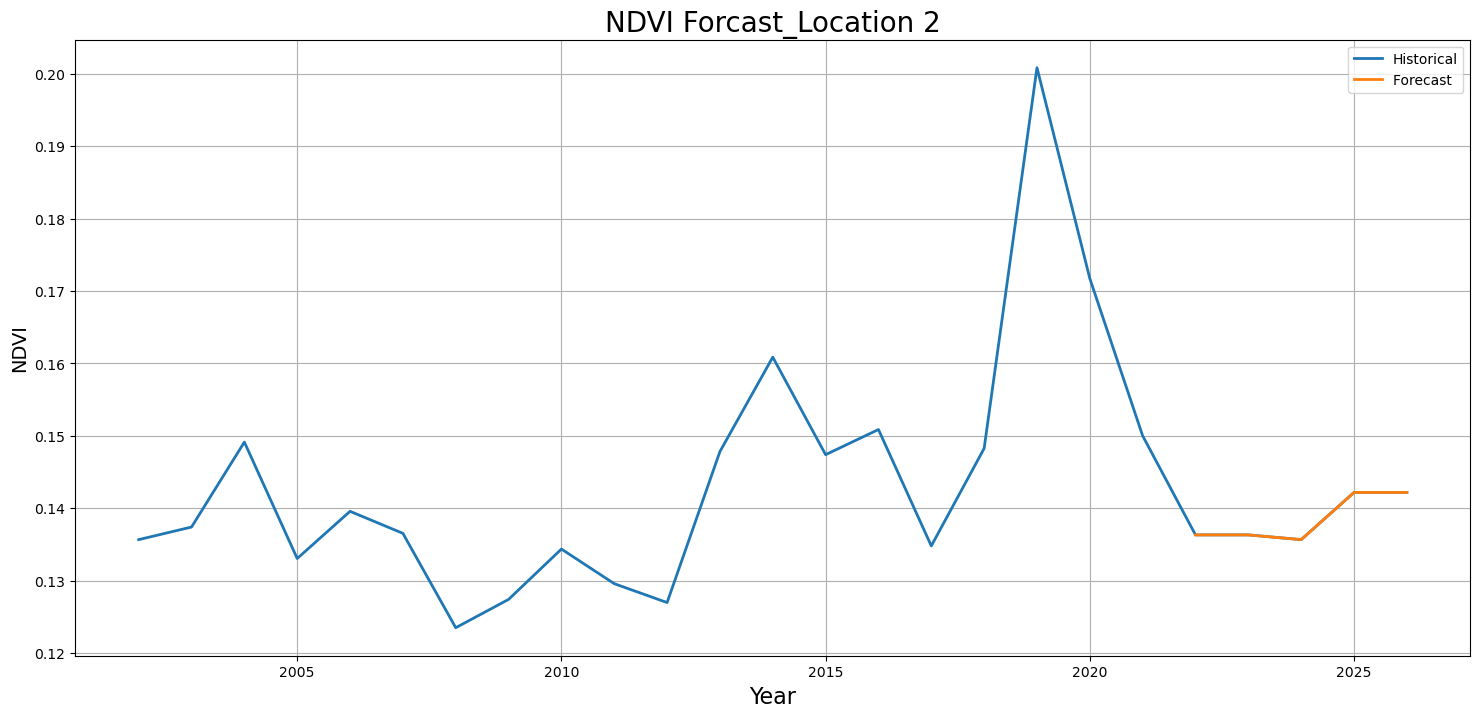

In [35]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L2_NDVI['year'], L2_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df2['year'], df2['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 2",fontsize=20)
ax.grid()
ax.legend();


# reference to codes at:

https://github.com/ledmaster/english_tutorials/blob/main/multiple_time_series/workshop_notebook.ipynb
